# Hamilton notebook extension
Jupyter magics are commands that can be executed in notebooks using `%` and `%%` in code cells.
- **Line magics** start with `%` and apply to the current line
- **Cell magics** start with `%%`, need to be the first line of a cell, and apply to the entire cell.

 You can think of them as Python decorators for lines and cells.

> For example, `%timeit complex_function()` will return the time to execute `complex_function()` and adding `%%timeit` will return the time to execute the entire cell.

This notebook is a tutorial on the Hamilton Jupyter magics and how they can improve your interactive development experience. It is meant to be read and have all cells executed linearly.

- **Section 2** - Dataflow definition
- **Section 3** - Dataflow execution

> ⚠ This notebook extension is something we're actively developing. If you find any bugs, edge cases, performance impacts, or if you have feature requests, let us know.

## 1. Loading the extension

To load our Jupyter Magic, we use `%load_ext` with the import path for the Python module (as if you did `import ...`). You only need to load it once, and will need to reload it if you restart the kernel just like you would for a Python module.

In [1]:
%load_ext hamilton.plugins.jupyter_magic
from hamilton import driver  # we'll need this later

After loading the extension, Hamilton magics become available:
- `%%cell_to_module`
- `%%set_driver`
- ...
Currently, the Hamilton plugin only defines cell magics. This notebook will cover them one-by-one, but if you need a quick refresher you can prepend `?` to get help.

In [2]:
?%%set_driver

Docstring:
Execute the cell and stores the defined Driver.

The cell can contain variable assignment, but only the first Driver
defined will be stored.
File:      ~/projects/dagworks/hamilton/hamilton/plugins/jupyter_magic.py

## 2. Define a Hamilton dataflow

### 2.1 Basics
The main magic is `%%cell_to_module` which turns a cell into a temporary Python module in-memory. Successful cell execution means it's a valid Hamilton dataflow and you can quickly visualize with the `--display / -d` argument.

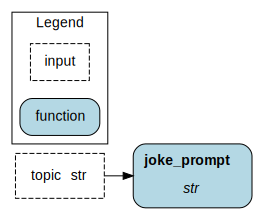

In [3]:
%%cell_to_module --display
def joke_prompt(topic: str) -> str:
    return f"Tell me a short joke about {topic}"

### 2.2 Module imports
Code found in cells with `%%cell_to_module` is treated like an isolated `.py` file. That means that you need to define Python imports in the cell itself. 

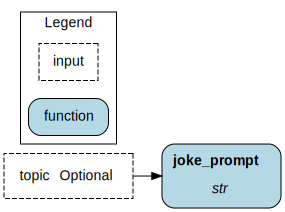

In [4]:
%%cell_to_module -d
from typing import Optional  # remove to get `NameError: name 'Optional' is not defined``

def joke_prompt(topic: Optional[str] = None) -> str:
    return f"Tell me a short joke about {topic}"

### 2.3 Module name
By default, using `%%cell_to_module` executes the cell content and creates a module named `jupyter_module`, making functions accessibles through the module namespace.

In [5]:
print(jupyter_module.joke_prompt("Open source"))

Tell me a short joke about Open source


By passing `--module_name / -m` you can specify a module name for a cell. This allows you to namespace functions to avoid conflicts.

In [6]:
%%cell_to_module --module_name knock
def joke_prompt(topic: str) -> str:
    return f"Knock, knock. Who's there? {topic}"

In [7]:
print(jupyter_module.joke_prompt("Cowsays"))
print(knock.joke_prompt("Cowsays"))

Tell me a short joke about Cowsays
Knock, knock. Who's there? Cowsays


### 2.4 Write module to file
To make the transition from notebook to module easy and avoid copy-pasting, you can use `--write_to_file / -w`. This will copy the content of the file to `{MODULE_NAME}.py`, which you can set with `--module_name` (see 2.3).

> ⛔ Be careful with overwriting files with this command. Use git to version your files.

After the running the next cell, you should see `knock.py` generated in your directory.

In [8]:
%%cell_to_module -m joke --write_to_file
def joke_prompt(topic: str) -> str:
    return f"Knock, knock. Who's there? {topic}"

In [9]:
import joke
joke.joke_prompt("Cowsays")

"Knock, knock. Who's there? Cowsays"

### 2.5 Config

The `Driver` definition can be required to properly build some Hamilton dataflow, in particular those using `.with_config() / @config` and `Parallelizable[]/Collect[]`.

To set these values, create a cell with `%%set_driver` and assign a Hamilton `Driver` to a variable. The magic will read the content of that variable and use it with your `%%cell_to_module`.

Notice that you don't need to specify a `.with_modules()` clause. 

In [3]:
%%set_driver
dr = (
    driver.Builder()
    .with_config({"knock_joke": "true"})
    # uncomment to allow Parallelizable / Collect
    #.enable_dynamic_execution(allow_experimental_mode=True)
    .build()
)

Notice in the next visualization how the `knock_joke` config matches the abover `Driver`. 

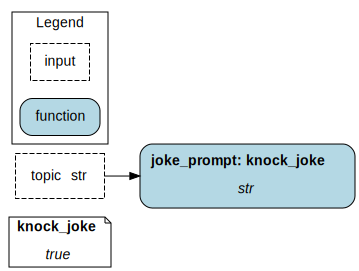

In [4]:
%%cell_to_module -m joke -d
from hamilton.function_modifiers import config

@config.when_not(knock_joke="true")
def joke_prompt__default(topic: str) -> str:
    return f"Tell me a short joke about {topic}"

@config.when(knock_joke="true")
def joke_prompt__knock(topic: str) -> str:
    return f"Knock, knock. Who's there? {topic}"

### 2.6 Load external modules
While developing your dataflow with `%%cell_to_module`, you might want to load nodes from another Python module. To do, simply import it and add it to the `Driver` using `.with_modules()` 

In [12]:
%%set_driver
import joke  # could be imported in another cell
dr = (
    driver.Builder()
    .with_modules(joke)
    .build()
)

The nodes `topic` and `joke_prompt` origin from `joke.py`

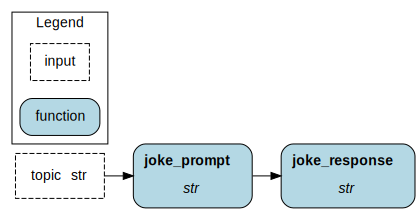

In [13]:
%%cell_to_module -d
def joke_response(joke_prompt: str) -> str:
    return f"{joke_prompt}\n\nCowsay who?"

### 2.7 Edit external modules
It is also possible to load the content of a Python module into a notebook cell to be able to edit it interactively!

This is essentially the reverse operation of `%%cell_to_module` hence why it's called `%module_to_cell`. This is a line magic (single `%`) and it reads the content of the line as a file path to a `.py` file.

In [14]:
# execute this to generate a new cell
%module_to_cell ./joke.py

In [ ]:
%%cell_to_module -m joke

def joke_prompt(topic: str) -> str:
    return f"Knock, knock. Who's there? {topic}"


If you executed the previous cell, a new code cell was created above with the content of `joke.py`.

You can add `--write_to_file` to write back the content of the notebook cell to a file.

## Intermission. A few more tips 
- The order of arguments after `%%cell_to_module` doesn't matter.
- Since only `-m` takes values (e.g., `-m MODULE_NAME`) and others are flags, you can write: 
    ```python
    %%cell_to_module -wdm joke
    ```
    To specify "write, display, module name" as long as `m` is last to receive the module name.
- To configure your visualization, add a cell with `%%set_display_config`. Each variable defined will be passed as keyword argument will be passed to the visualization function. ([reference](https://hamilton.dagworks.io/en/latest/reference/drivers/Driver/#hamilton.driver.Driver.display_all_functions))

In [15]:
%%set_display_config
orient="TB"  # sets orientation Top to Bottom

Also, we'll remove the previous `Driver` defined by `%%cell_to_module`

In [16]:
%%set_driver
dr = driver.Builder().build()

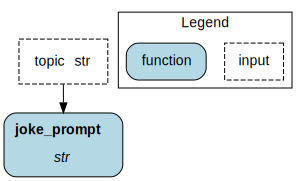

In [17]:
%%cell_to_module -dm joke
def joke_prompt(topic: str) -> str:
    return f"Knock, knock. Who's there? {topic}"

In [18]:
%%set_display_config
orient="LR"  # sets orientation Left to Right

## 3. Execute a dataflow
One of the best part about notebooks is the ability to execute and immediately inspect results. They provide a "read-eval-print" loop (REPL) coding experience. However, the way Hamilton separates dataflow definition (functions in a module) from execution (building and executing a driver) creates an extra step that can slowdown this loop.

We built the Hamilton notebook extension to tighten that loop and even give a better experience than the core notebook experience! 

### 3.1 Naive approach

If you're familiar with Hamilton, you probably figured out that you can build a `Driver` from the dynamically defined modules (like the next cell). But we have better interactive options!

In [19]:
dr = driver.Builder().with_modules(joke).build()
results = dr.execute(["joke_prompt"], inputs=dict(topic="Cowsay"))
results

{'joke_prompt': "Knock, knock. Who's there? Cowsay"}

We call it the "naive approach" because this was one of the main development bottleneck we tried to overcome with this notebook extension. Let's take a moment to appreciate its limitations:

1. As we define new nodes, we need to add them to `.execute()`.
2. To interact with results, we need to get them from the dictionary by specifying keys as string. This step has no IDE completion and becomes tedious when inspecting multiple variables.
3. Frequent refactoring and renaming means the `.execute()` and the results inspection code mentioned aboved is quickly outdated.

### 3.2 Execute module cell
By adding `--execute / -x` to your module definition, executing the cell will call `Driver.execute()` with all available nodes. This way, whenever you add a function, you won't have to manually add it's name to `.execute()` and call it (limitation 1).

The visualization produced by `--display` should now include **output** nodes reflecting the executed nodes.

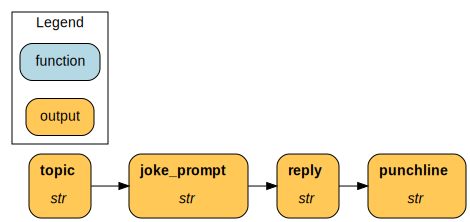

In [20]:
%%cell_to_module -dm joke --execute
def topic() -> str:
    return "Cowsay"

def joke_prompt(topic: str) -> str:
    return f"Knock, knock. Who's there? {topic}"

def reply(joke_prompt: str) -> str:
    _, _, right = joke_prompt.partition("? ")
    return f"{right} who?"

def punchline(reply: str) -> str:
    left, _, _ = reply.partition(" ")
    return f"No, {left} MooOOooo"

Ok, but how do you access results? With the node name! Magic 🧙

In [21]:
punchline

'No, Cowsay MooOOooo'

When executing the cell, we are effectively:
1. Loading it's content as a module
2. Building a `Driver` with this module
3. Executing the module with all nodes
4. Assigning values from the results of `.execute()` to variables

This means that functions defined in `%%cell_to_node` might be replaced by their "value". If you need to access the functions directly, you can always access them through their module like below:

In [22]:
joke.punchline("Cowsays")

'No, Cowsays MooOOooo'

### 3.3 Requesting nodes
If you don't want to execute all nodes, you can create a cell with `%%set_final_vars` and define a list with node names. The next time you execute a `%%cell_to_module`, only the specified cells will be executed, which will be reflected in the visualization.

In [23]:
%%set_final_vars
final_vars = ["reply"]

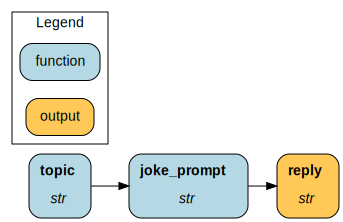

In [24]:
%%cell_to_module -dm joke --execute
def topic() -> str:
    return "Cowsay"

def joke_prompt(topic: str) -> str:
    return f"Knock, knock. Who's there? {topic}"

def reply(joke_prompt: str) -> str:
    _, _, right = joke_prompt.partition("? ")
    return f"{right} who?"

def punchline(reply: str) -> str:
    left, _, _ = reply.partition(" ")
    return f"No, {left} MooOOooo"

If you pass `--all`, you will toggle back to executing all defined nodes, despite the specified node names

In [25]:
%%set_final_vars --all
final_vars = ["reply"]

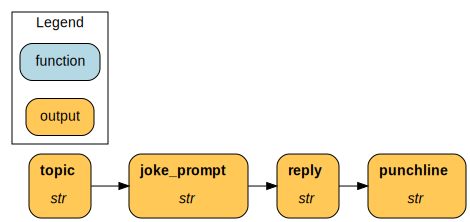

In [26]:
%%cell_to_module -xdm joke
def topic() -> str:
    return "Cowsay"

def joke_prompt(topic: str) -> str:
    return f"Knock, knock. Who's there? {topic}"

def reply(joke_prompt: str) -> str:
    _, _, right = joke_prompt.partition("? ")
    return f"{right} who?"

def punchline(reply: str) -> str:
    left, _, _ = reply.partition(" ")
    return f"No, {left} MooOOooo"

### 3.4 Inputs & overrides
In Hamilton, *inputs*  are values external to the dataflow and *overrides* are values to replace the output of a node (it effectively skips upstream operations).

You can set these values by assigning variables in cells with `%%set_inputs` or `%%set_overrides`.

In [27]:
%%set_inputs
topic = "Cowsay"

In [28]:
%%set_overrides
punchline = "Bingo bongo!"

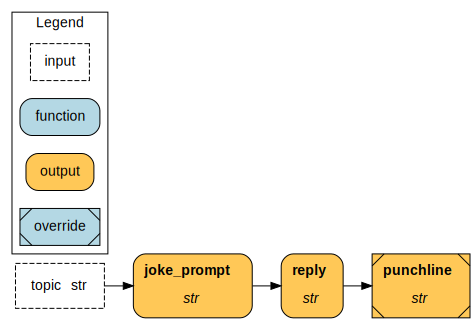

In [29]:
%%cell_to_module -xdm joke
def joke_prompt(topic: str) -> str:
    return f"Knock, knock. Who's there? {topic}"

def reply(joke_prompt: str) -> str:
    _, _, right = joke_prompt.partition("? ")
    return f"{right} who?"

def punchline(reply: str) -> str:
    left, _, _ = reply.partition(" ")
    return f"No, {left} MooOOooo"

In [30]:
print(joke_prompt)  # input
print(reply)
print(punchline)  # override

Knock, knock. Who's there? Cowsay
Cowsay who?
Bingo bongo!


### 3.5 Driver Adapters
You can use `%%set_driver` to modify execution by adding adapters to the `Driver`. Adapters are flexible tools that can provide a variety of features.

For instance, the next few cells uses `PrintLn()` to execution status after each node.

In [31]:
%%set_driver
from hamilton.lifecycle.default import PrintLn
dr = (
    driver.Builder()
    .with_adapters(PrintLn())  # add the adapter
    .build()
)

Notice in the printed statement how the overriden `punchline` node isn't executed.

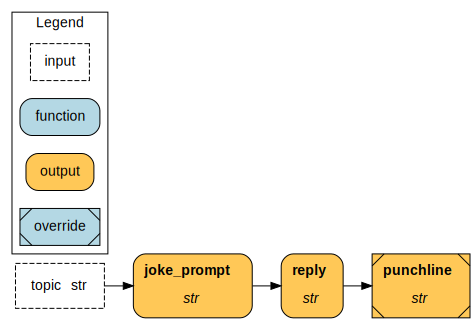

Executing node: joke_prompt.
Finished debugging node: joke_prompt in 60.6μs. Status: Success.
Executing node: reply.
Finished debugging node: reply in 13.4μs. Status: Success.


In [32]:
%%cell_to_module -xdm joke
def joke_prompt(topic: str) -> str:
    return f"Knock, knock. Who's there? {topic}"

def reply(joke_prompt: str) -> str:
    _, _, right = joke_prompt.partition("? ")
    return f"{right} who?"

def punchline(reply: str) -> str:
    left, _, _ = reply.partition(" ")
    return f"No, {left} MooOOooo"

There are ton of awesome adapters that can help you with your notebook experience. Here are a few notable mentions:

1. `hamilton.lifecycle.default.CacheAdapter()` will automatically version the node's code and input values and store its result on disk. When running the same node (code, inputs) pair, it will read the value from disk instead of recomputing. This can help save LLM API costs!
2. `hamilton.plugins.h_diskcache.DiskCacheAdapter()` same core features as `CacheAdapter()`, but more utilities around cache management
3. `hamilton.lifecycle.default.PrintLn()` print execution status.
4. `hamilton.plugins.h_tqdm.ProgressBar()` add a progress bar for execution.
5. `hamilton.lifecycle.default.PDBDebugger()` allows you to step into a node with a Python debugger, allowing you to execute code line by line.

Note that all of these adapters work with Hamilton outside notebooks too!